# Notebook 04
- Preparação dos dados


# 0.0 Imports

In [10]:
import os
import pathlib
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns
import numpy             as np

from sklearn.preprocessing import RobustScaler , MinMaxScaler, LabelEncoder
from scipy                 import stats as ss
from IPython.core.display  import HTML

import warnings
warnings.filterwarnings("ignore")

## 0.1 Helper Functions

In [2]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2 File and directory paths

In [34]:
# Diretório raíz
PACKAGE_ROOT = pathlib.Path('.').resolve().parent

# Caminhos para os diretórios dos dados
DATADIR = os.path.join(PACKAGE_ROOT, 'data')
DATADIR_PREPROCESSED = os.path.join(DATADIR, 'preprocessed')
DATADIR_INTERIM = os.path.join(DATADIR, 'interim')

# Caminhos para os diretórios de documentos
DOCDIR = os.path.join(PACKAGE_ROOT, 'docs')
IMAGEDIR = os.path.join(DOCDIR, 'Image')

# Files Preprocessed Data
FILE_PREPROCESSED_V1 = os.path.join(DATADIR_PREPROCESSED,'data_preprocessed_v1.csv')

## 0.3 Data loading
**Carregando os dados em que as lojas estavam abertas**

In [4]:
df = pd.read_csv(FILE_PREPROCESSED_V1)
df = df.drop(columns='Unnamed: 0')
df['date']=pd.to_datetime(df['date'])
df['promo_since']=pd.to_datetime(df['promo_since'])
df['competition_since']=pd.to_datetime(df['competition_since'])
#df['year_week']=pd.to_datetime(df['year_week'])


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844392 entries, 0 to 844391
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   store                         844392 non-null  int64         
 1   day_of_week                   844392 non-null  int64         
 2   date                          844392 non-null  datetime64[ns]
 3   sales                         844392 non-null  int64         
 4   open                          844392 non-null  int64         
 5   promo                         844392 non-null  int64         
 6   state_holiday                 844392 non-null  object        
 7   school_holiday                844392 non-null  int64         
 8   store_type                    844392 non-null  object        
 9   assortment                    844392 non-null  object        
 10  competition_distance          844392 non-null  float64       
 11  competition_o

# 1.0 Data preparation

In [28]:
df1 = df.copy()

## 1.1 Normalização

Como não há variáveis numéricas com distribuição normal, então não precisa utilizar esse tipo de transformação de escala.

## 1.2 Rescaling

**Na presença de outliers podemos utilizar o RobustScaler para a transformação dos dados em uma nova escala, e caso não tenha outliers, poderá ser utilizado o método MinMaxScaler**

In [29]:
rs = RobustScaler()
mms = MinMaxScaler()


# competition_distance
df1['competition_distance'] = rs.fit_transform(df1[['competition_distance']].values) # Coloca-se dois colchetes para pegar o valor da coluna.

# year - sem outlier
df1['year'] = mms.fit_transform(df1[['year']].values)

# competition time month
df1['competition_time_month'] = rs.fit_transform(df1[['competition_time_month']].values)

# promo time week - sem outlier
df1['promo_time_week'] = mms.fit_transform(df1[['promo_time_week']].values)

## 1.3 Encoding

In [30]:
# state_holiday - Método OHE (Get_dummies)
df1 = pd.get_dummies(df1,prefix=['state_holiday'], columns=['state_holiday'])

# store_type - Label Encoder (Aleatoriamente trocando as letras por números)
le = LabelEncoder()
df1['store_type'] = le.fit_transform(df1['store_type'])

# assortment - Ordinal (Esse método deve ser utilizado uma vez que temos uma ordem de grandeza em relação as categorias)
dict_assortment = {'basic':0,
                    'extra': 2,
                    'extended':3}
df1['assortment'] = df1['assortment'].map(dict_assortment)


## 1.4 Transformation

### 1.4.1 Responsible Variable transformation

Fazendo com o que a Variável resposta tenha uma distribuição mais próxima da normal. Nesse ciclo, iremos utilizar o método de transformação logarítimica.

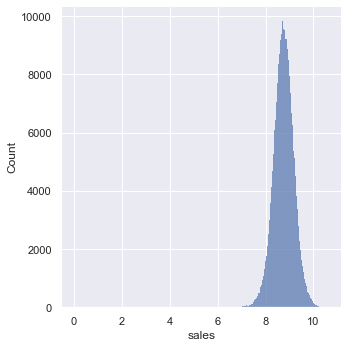

In [31]:
df1['sales'] = np.log1p(df1['sales'])
sns.displot(df1['sales'])

### 1.4.2 Transformação cíclica

In [33]:
# day_of_week
df1['day_of_week_sin']= df1['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df1['day_of_week_cos']= df1['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

# month
df1['month_sin']= df1['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df1['month_cos']= df1['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df1['day_sin']= df1['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df1['day_cos']= df1['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week of year
df1['weekofyear_sin']= df1['weekofyear'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df1['weekofyear_cos']= df1['weekofyear'].apply(lambda x: np.cos(x * (2. * np.pi/52)))


## 1.5 Save Data

In [36]:
name_new_file = 'data_interim_ciclo01.csv'
name_new_file = os.path.join(DATADIR_INTERIM,name_new_file)
df1.to_csv(name_new_file)